In [5]:
from torchvision.datasets import Food101
from torchvision.datasets import Flowers102
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
batch_size = 2
down_level_quntize = 6
crop_shape = (64, 64)
num_workers = 2

In [7]:
transform = transforms.Compose([
    transforms.RandomCrop((256, 256)),
    transforms.Resize(crop_shape),
    transforms.Grayscale(),
    transforms.ToTensor()
])
train_flower_dataset = Flowers102(root='.',split = 'train', download=True, transform =transform)
test_flower_dataset = Flowers102(root='.',split = 'test', download=True, transform =transform)
validation_dataset = Flowers102(root='.',split = 'val', download=True, transform =transform)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

In [8]:
data ={
    'flower_train':DataLoader(train_flower_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers),
    'flower_test':DataLoader(test_flower_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers),
    'flower_validation':DataLoader(validation_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
} 

In [9]:
def round_bits(x, quantize_bits):
    mul = 2**quantize_bits
    x = x * mul
    x = torch.floor(x)
    x = x / mul
    return x

class Encoder(nn.Module):
    def __init__(self, image_shape):
        super(Encoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),            
            )
        self.fc1 = nn.Sequential(
            nn.Linear(int(image_shape[0]/8) * int(image_shape[1]/8)*16,  image_shape[0]*image_shape[1]),
        )
        
        self.image_shape = image_shape
    def forward(self, x, quantize_bits=None):
        batch_size = x.shape[0]
        x = self.encoder(x)
        x = x.reshape(batch_size, -1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        if quantize_bits is not None:
            x = round_bits(x, quantize_bits)
        x = torch.logit(x, eps=0.001)
        x = x.reshape((batch_size,1,self.image_shape[0],self.image_shape[1]))
        return x

In [10]:
class Decoder(nn.Module):
    def __init__(self, input_shape):
        super(Decoder, self).__init__()
        self.stage1_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.stage1_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.stage2_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.stage2_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.stage3_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.stage3_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.stage4_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.stage4_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.encoder_block1_1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.encoder_block1_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.encoder_block2_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.encoder_block2_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.encoder_block3_1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.encoder_block3_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.encoder_block3_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )
        
        
        
    def forward(self, x):
        x = self.stage1_1(x)
        x1 = self.stage1_2(x)
        x = self.max_pool1(x1)
        x = self.stage2_1(x)
        x2 = self.stage2_2(x)
        x = self.max_pool2(x2)
        x = self.stage3_1(x)
        x3 = self.stage3_2(x)
        x = self.max_pool3(x3)
        x = self.stage4_1(x)
        x = self.stage4_2(x)
        x = self.encoder_block1_1(x)
        x = self.encoder_block1_2(x) + x3
        x = self.encoder_block2_1(x)
        x = self.encoder_block2_2(x) + x2
        x = self.encoder_block3_1(x)
        x = self.encoder_block3_2(x) + x1
        x = self.encoder_block3_3(x)
        x = torch.tanh(x)

        return x

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape)
        self.decoder = Decoder(input_shape)

    def forward(self, x, quantize_bits):
        x = self.encoder(x, quantize_bits)
        x = self.decoder(x)
        return x

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.new_shape = int(input_shape[0]/4**3)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxPool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.maxPool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.maxPool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * self.new_shape ** 2,self.new_shape ** 2)
        self.fc2 = nn.Linear(self.new_shape ** 2, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        #x = self.maxPool1(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.maxPool2(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = self.maxPool3(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = self.maxPool4(x)
        
#         x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)
#         x = self.maxPool5(x)
#         x = F.leaky_relu(self.bn5(self.conv6(x)), 0.2)
#         x = self.maxPool6(x)
        x = x.view(-1, 64 * self.new_shape ** 2)  
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [13]:
# Initialize the generator and discriminator
autoencoder = Autoencoder(crop_shape)
discriminator = Discriminator(crop_shape)
# Define the loss function and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(autoencoder.parameters(), lr=0.0002)

In [14]:
# # releasing CUDA memory
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()        

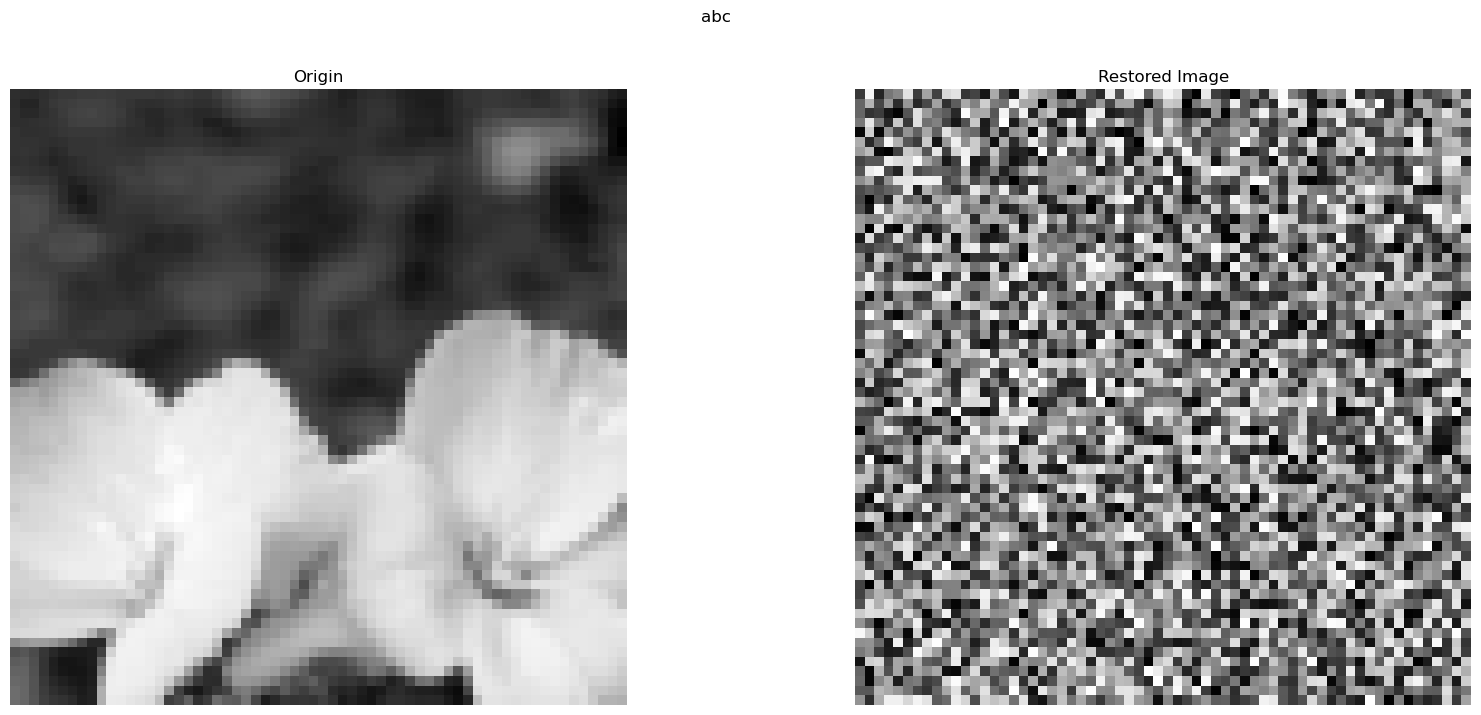

In [15]:
# load state dicts
import torch.optim as optim
autoencoder = Autoencoder(crop_shape)
discriminator = Discriminator(crop_shape)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
g_optimizer = optim.Adam(autoencoder.parameters(), lr=0.0002)
# mean-squared error loss
criterion = nn.MSELoss()

# # load weights from file

# #file_name = 'path-to-pt-file'

# checkpoint = torch.load(file_name)

# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['generator_state_dict'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v

# autoencoder.load_state_dict(new_state_dict)
# new_state_dict_discri = OrderedDict()
# for k, v in checkpoint['discriminator_state_dict'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict_discri[name] = v

# # load params

# discriminator.load_state_dict(new_state_dict_discri)

# print("finished loading state dicts!")
import random
# exapmle image
t = transforms.ToPILImage()
real_image, _= random.choice(test_flower_dataset)
output = autoencoder(real_image, 6)
restored_image = t(output[0])

# Create a figure with 3 subplots and a title
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("abc")

# Display the first image in the first subplot
axs[0].imshow(real_image[0], cmap='gray')
axs[0].axis("off")
axs[0].set_title("Origin")
axs[1].imshow(restored_image, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Restored Image")
plt.savefig("_Test2.png")
plt.show()


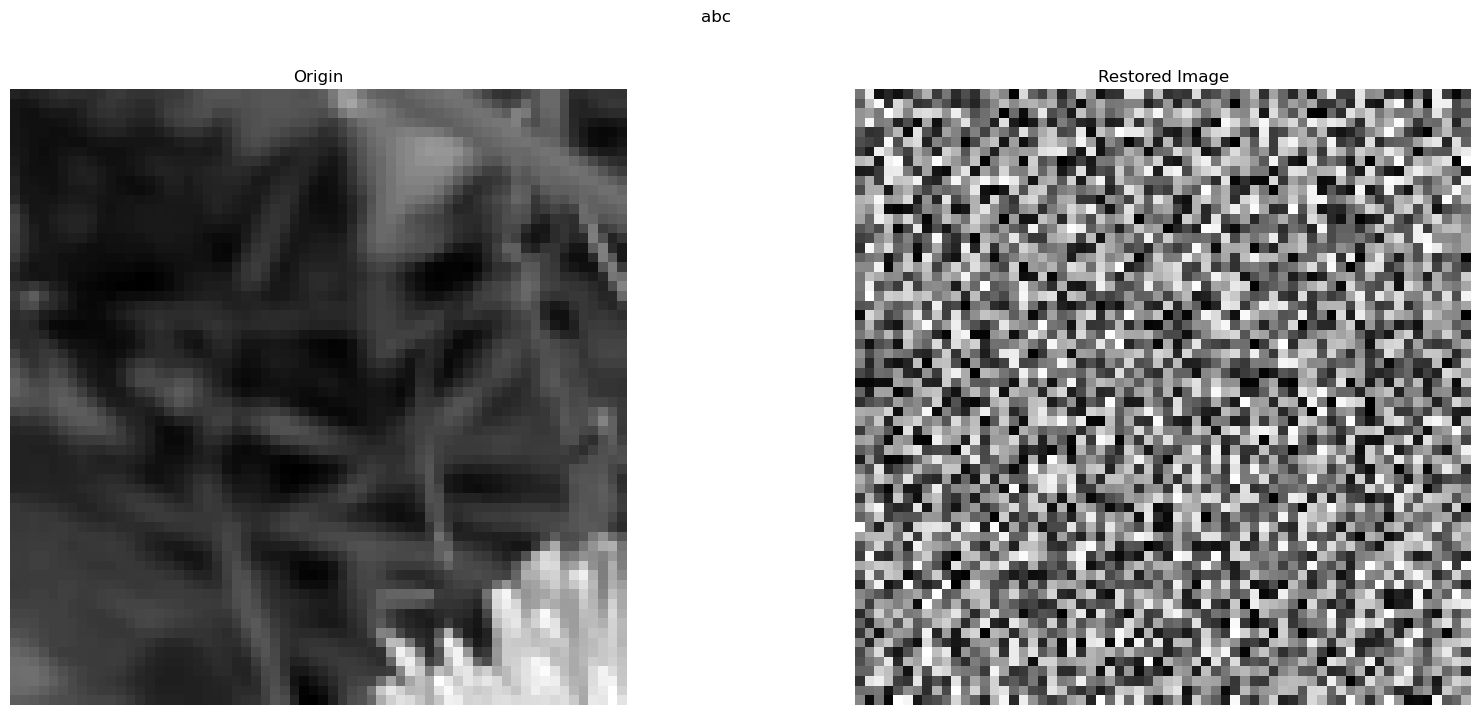

epoch : 1/1000, Generator loss = 0.064495, mse_loss = 0.064999,Discriminator loss = 0.886654, Validation loss = 0.015955


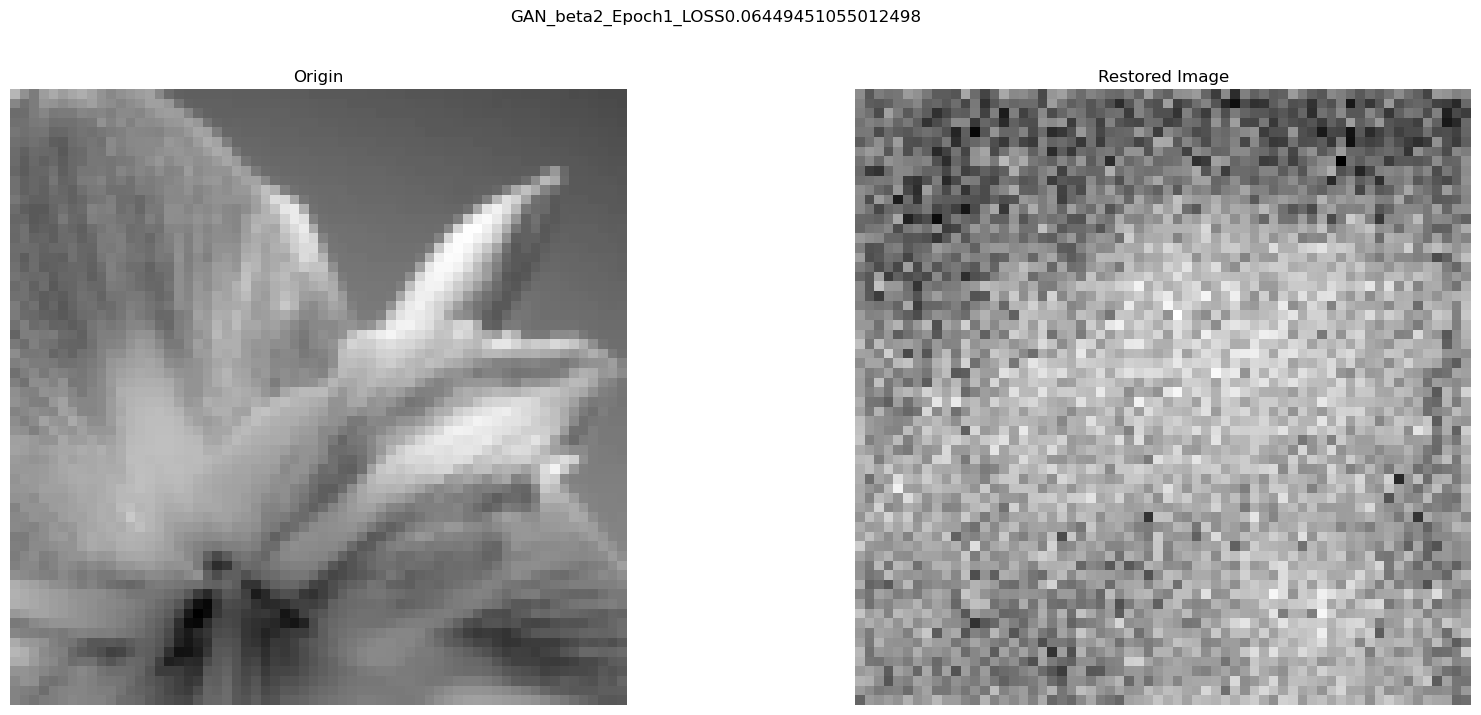

epoch : 2/1000, Generator loss = 0.042889, mse_loss = 0.043321,Discriminator loss = 0.977857, Validation loss = 0.008123
epoch : 3/1000, Generator loss = 0.030902, mse_loss = 0.031214,Discriminator loss = 0.986948, Validation loss = 0.005369
epoch : 4/1000, Generator loss = 0.026982, mse_loss = 0.027254,Discriminator loss = 0.990814, Validation loss = 0.003973
epoch : 5/1000, Generator loss = 0.025303, mse_loss = 0.025559,Discriminator loss = 0.993027, Validation loss = 0.003104
epoch : 6/1000, Generator loss = 0.024086, mse_loss = 0.024329,Discriminator loss = 0.994480, Validation loss = 0.002479


In [ ]:
def get_validation_loss(autoencoder, discriminator):
    correct_count = 0
    total_img = 0
    for val_image in validation_loader:
        val_image = val_image[0]
        val_image = val_image.to(device)
        fake_data = autoencoder(val_image, 6)
        desicion = discriminator(fake_data)
#         print(desicion[0].item())
        correct_count += 1 - desicion[0].item()
        correct_count += 1 - desicion[1].item()
        total_img += 2
    return correct_count / total_img

import random
save_every_epoch = 50
model_name = 'GAN_beta2'
epochs=1000
#train_loader = train_all_batchs
train_loader = data["flower_train"]
validation_loader = data["flower_validation"]

t = transforms.ToPILImage()
real_image, _= random.choice(test_flower_dataset)
output = autoencoder(real_image, 6)
restored_image = t(output[0])

# Create a figure with 3 subplots and a title
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("abc")

# Display the first image in the first subplot
axs[0].imshow(real_image[0], cmap='gray')
axs[0].axis("off")
axs[0].set_title("Origin")
axs[1].imshow(restored_image, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Restored Image")
plt.show()

autoencoder.to(device)
discriminator.to(device)
autoencoder = torch.nn.DataParallel(autoencoder)
discriminator = torch.nn.DataParallel(discriminator)
        
t = transforms.ToPILImage()
image = random.choice(train_flower_dataset)[0]
t(image)


for epoch in range(epochs):
    loss_D = 0
    loss_G = 0
    mse_loss_total = 0
    for gb_image in train_loader:
        gb_image = gb_image[0]
        gb_image = gb_image.to(device)
        
        discriminator.zero_grad()
        d_real_decision = discriminator(gb_image)
        d_real_error = criterion(d_real_decision, torch.ones(d_real_decision.shape[0],1).to(device))
        d_real_error.backward()
        
        fake_data = autoencoder(gb_image, down_level_quntize)
        d_fake_decision = discriminator(fake_data.to(device))
        d_fake_error = criterion(d_fake_decision, torch.zeros(d_fake_decision.shape[0],1).to(device))

        errD = d_fake_error + d_real_error
        d_optimizer.step()
        
        autoencoder.zero_grad()
        fake_data = autoencoder(gb_image, down_level_quntize)
        d_fake_decision = discriminator(fake_data.to(device))
        # Add the MSE loss between fake_data and target_image
        g_error = criterion(d_fake_decision, torch.ones(d_fake_decision.shape[0],1).to(device))
        mse_loss = nn.MSELoss()(fake_data, gb_image)
        g_error = 0.01 * g_error + 0.99 * mse_loss
        fake_data.detach()
        g_error.backward()
        g_optimizer.step()
        
        loss_D +=errD.item()
        loss_G +=g_error.item()
        mse_loss_total+=mse_loss.item()
        
    # compute the epoch training loss
    loss_D = loss_D / len(train_loader)
    loss_G = loss_G / len(train_loader) 
    mse_loss_total = mse_loss_total / len(train_loader) 
    Validation_loss = get_validation_loss(autoencoder, discriminator)
    # display the epoch training loss
    print("epoch : {}/{}, Generator loss = {:.6f}, mse_loss = {:.6f},Discriminator loss = {:.6f}, Validation loss = {:.6f}"
          .format(epoch + 1, epochs, loss_G,mse_loss_total, loss_D, Validation_loss))
    
    if (epoch+1)%save_every_epoch == 0:
        torch.save({
            'generator_state_dict': autoencoder.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
        }, "model_and_optimizer_"+model_name+"_"+str(epoch+1)+".pt")

    if (epoch)%(save_every_epoch / 5) == 0:    
        try: 
            # SAVE FIGURE

                t = transforms.ToPILImage()
                real_image, _= random.choice(test_flower_dataset)
                output = autoencoder(real_image, 6)
                restored_image = t(output[0])

                # Create a figure with 3 subplots and a title
                fig, axs = plt.subplots(1, 2, figsize=(20, 8))
                fig.suptitle(model_name+"_Epoch"+str(epoch+1)+"_LOSS"+str(loss_G))

                # Display the first image in the first subplot
                axs[0].imshow(real_image[0], cmap='gray')
                axs[0].axis("off")
                axs[0].set_title("Origin")
                axs[1].imshow(restored_image, cmap='gray')
                axs[1].axis("off")
                axs[1].set_title("Restored Image")
                plt.savefig(model_name+"_Epoch"+str(epoch+1))
                plt.show()
    #                 
            
        except:
            print("image plotting failed")

In [ ]:
import torch.optim as optim
autoencoder = Autoencoder(crop_shape)
discriminator = Discriminator(crop_shape)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
g_optimizer = optim.Adam(autoencoder.parameters(), lr=0.0002)
# mean-squared error loss
criterion = nn.MSELoss()

# load from file
file_name = '/kaggle/input/model-and-optimizer-gan-beta2-700pt/model_and_optimizer_GAN_beta2_700.pt'
checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in checkpoint['generator_state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

autoencoder.load_state_dict(new_state_dict)




new_state_dict_discri = OrderedDict()
for k, v in checkpoint['discriminator_state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict_discri[name] = v


# load params

discriminator.load_state_dict(new_state_dict_discri)

# -------------------------------------------------------------------------------------------------------

t = transforms.ToPILImage()
real_image, _= random.choice(test_flower_dataset)
output = autoencoder(real_image, 6)
restored_image = t(output[0])

# Create a figure with 3 subplots and a title
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("test")

# Display the first image in the first subplot
axs[0].imshow(real_image[0], cmap='gray')
axs[0].axis("off")
axs[0].set_title("Origin")
axs[1].imshow(restored_image, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Restored Image")
plt.show()






In [ ]:
# example for usage in model
t = transforms.ToPILImage()
real_image, _= random.choice(test_flower_dataset)
output = autoencoder(real_image, 6)
restored_image = t(output[0])

# Create a figure with 3 subplots and a title
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("abc")

# Display the first image in the first subplot
axs[0].imshow(real_image[0], cmap='gray')
axs[0].axis("off")
axs[0].set_title("Origin")
axs[1].imshow(restored_image, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Restored Image")
plt.show()

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, "model_and_optimizer.pt")